In [10]:
# Load all packages used
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

print(f'TensorFlow version is {tf.__version__}')

# This python way of importing is annoying
import mypackage; import importlib
from mypackage.data import DataSet
importlib.reload(mypackage.data);
# Here ends the importing annoyance

TensorFlow version is 2.1.0


In [11]:
# Collect the 4-7 channel images and scale them
X, Y, info = DataSet.load("data/sample", channels_to_use=[1,2,6])

[ 0  3  5 10 13 15 39]


In [12]:
######################################################
# Stuff to be refined and moved to correct locations #

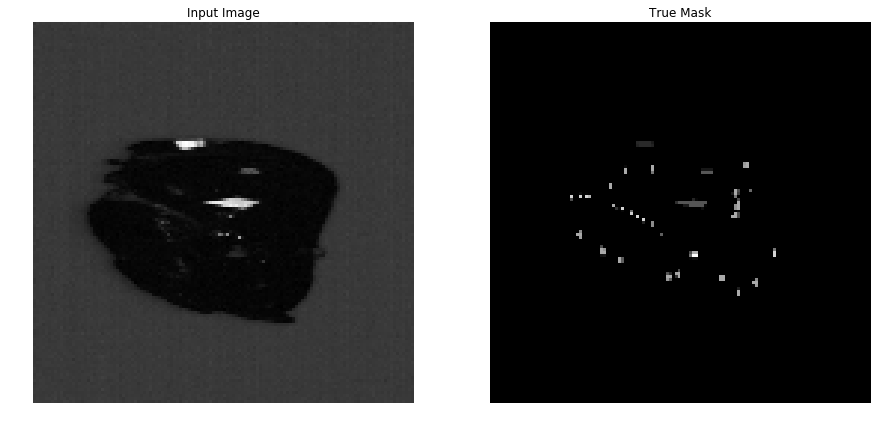

In [13]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(image, label):
    input_image = tf.image.resize(image, (128, 128))
    input_mask = tf.image.resize(label, (128, 128))

    # if tf.random.uniform(()) > 0.5:
    #     input_image = tf.image.flip_left_right(input_image)
    #     input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(image, label):
    input_image = tf.image.resize(image, (128, 128))
    input_mask = tf.image.resize(label, (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

TRAIN_LENGTH = 1
BATCH_SIZE = 1
BUFFER_SIZE = 1 # What is this?
STEPS_PER_EPOCH = 1

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(1):
    sample_image, sample_mask = image[:,:,2:5], mask
display([sample_image, sample_mask])

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
from tensorflow_examples.models.pix2pix import pix2pix

OUTPUT_CHANNELS = 7

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is losses.sparse_categorical_crossentropy. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.sparse_categorical_crossentropy is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

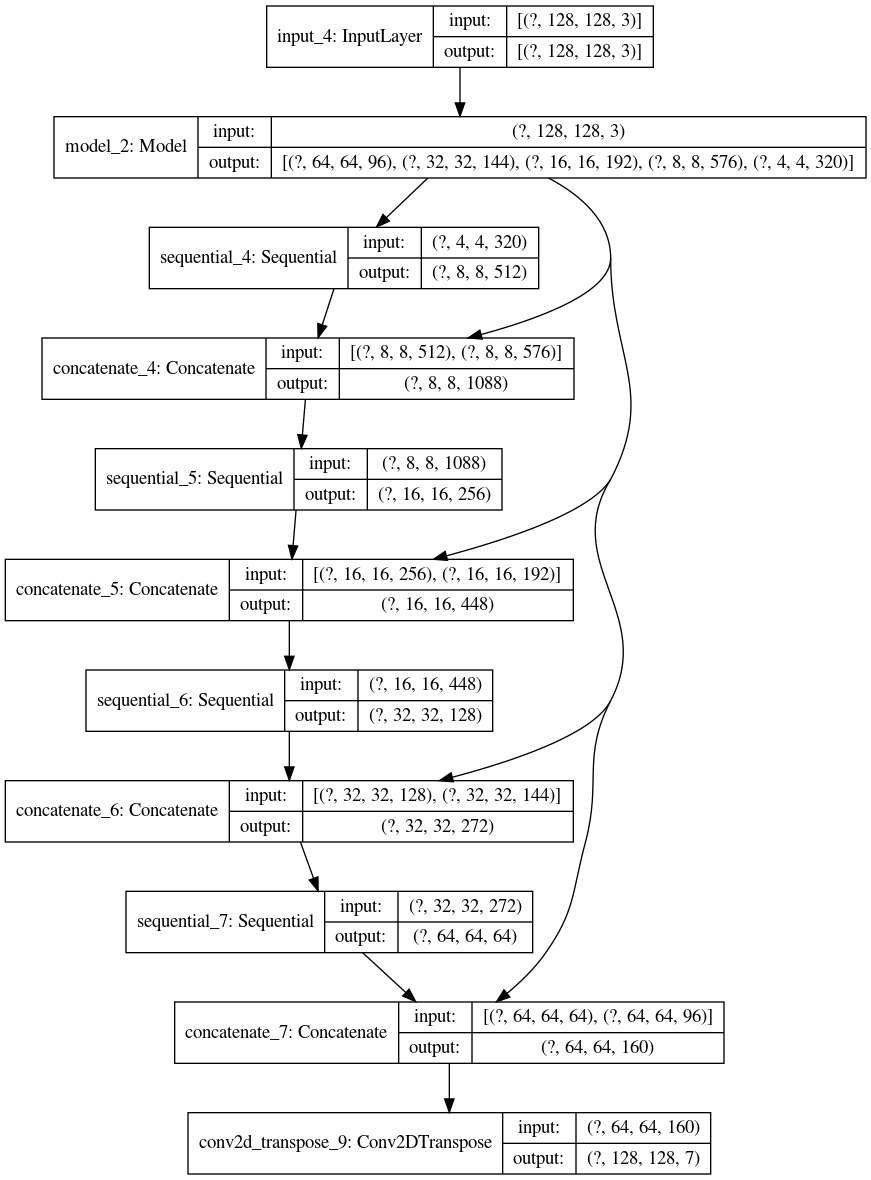

In [15]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

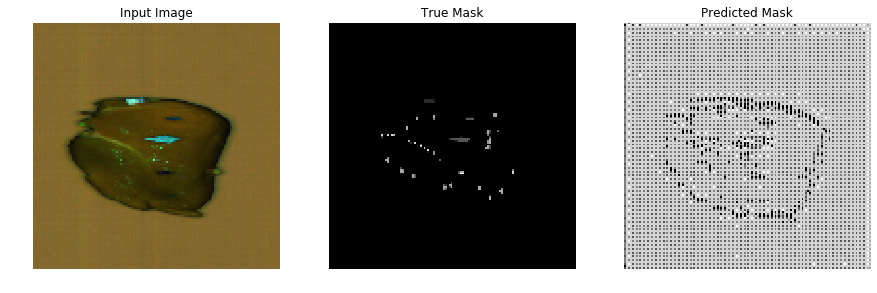

In [16]:
# Let's try out the model to see what it predicts before training.

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])

show_predictions(test_dataset)

In [17]:
# Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.
# class DisplayCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     clear_output(wait=True)
#     show_predictions()
#     print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
EPOCHS = 20
VAL_SUBSPLITS = 1
VALIDATION_STEPS = 1

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)#,
                        #   callbacks=[DisplayCallback()])

Train for 1 steps, validate for 1 steps
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 2.4819 - accuracy: 0.0775 - val_loss: 1.8184 - val_accuracy: 0.2647
Epoch 2/20
1/1 [==============================] - 0s 102ms/step - loss: 1.9069 - accuracy: 0.2925 - val_loss: 1.4418 - val_accuracy: 0.4849
Epoch 3/20
1/1 [==============================] - 0s 108ms/step - loss: 1.4556 - accuracy: 0.4573 - val_loss: 1.1357 - val_accuracy: 0.5201
Epoch 4/20
1/1 [==============================] - 0s 102ms/step - loss: 1.1102 - accuracy: 0.5679 - val_loss: 0.8862 - val_accuracy: 0.6489
Epoch 5/20
1/1 [==============================] - 0s 109ms/step - loss: 0.8400 - accuracy: 0.6732 - val_loss: 0.6830 - val_accuracy: 0.8073
Epoch 6/20
1/1 [==============================] - 0s 108ms/step - loss: 0.6284 - accuracy: 0.8112 - val_loss: 0.5214 - val_accuracy: 0.9667
Epoch 7/20
1/1 [==============================] - 0s 105ms/step - loss: 0.4670 - accuracy: 0.9293 - val_loss: 0.3974 - val_

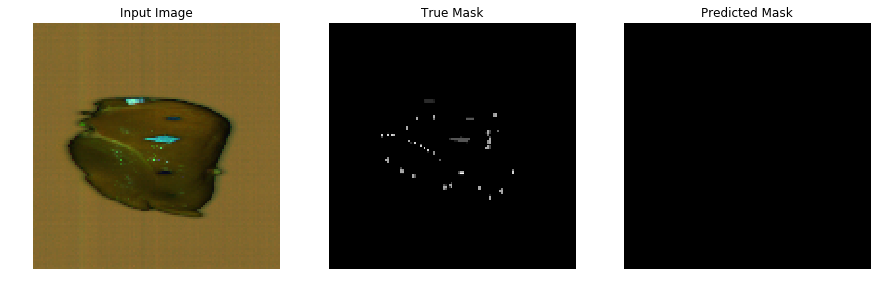

In [18]:
show_predictions(test_dataset)

In [21]:
for image, mask in test_dataset.take(1):
      pred_mask = model.predict(image)
      print(np.unique(create_mask(pred_mask)))

[0]


In [ ]:
# Stuff to be refined and moved to correct locations #
######################################################

In [ ]:
# Build/select the model
# https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb

In [11]:
# Train the model
import os
print(os.getcwd())

/home/thor/HI/Lokaverkefni/Code


In [ ]:
# Evaluate the result


In [55]:
data = DataSet.read_tiff('data/sample/labels/chicken_fm.tif', channels_to_use=[0])
np.unique(data)

array([  3,   5,  10,  13,  15,  39, 214, 231, 247, 255], dtype=uint8)